##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 量子畳み込みニューラルネットワーク

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/qcnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png"> Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/quantum/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/quantum/tutorials/qcnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

このチュートリアルでは、単純な<a href="https://www.nature.com/articles/s41567-019-0648-8" class="external">量子畳み込みニューラルネットワーク</a>（QCNN）を実装します。QCNN は、*並進的に不変*でもある古典的な畳み込みニューラルネットワークに提案された量子アナログです。

この例では、デバイスの量子センサまたは複雑なシミュレーションなど、量子データソースの特定のプロパティを検出する方法を実演します。量子データソースは、励起の有無にかかわらず<a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">クラスタ状態</a>です。QCNN はこの検出を学習します（論文で使用されたデータセットは SPT フェーズ分類です）。

## セットアップ

In [2]:
!pip install -q tensorflow==2.3.1

TensorFlow Quantum をインストールします。

In [3]:
!pip install -q tensorflow-quantum

次に、TensorFlow とモジュールの依存関係をインポートします。

In [4]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## 1. QCNN を構築する

### 1.1 TensorFlow グラフで回路を組み立てる

TensorFlow Quantum（TFQ）には、グラフ内で回路を構築するために設計されたレイヤークラスがあります。たとえば `tfq.layers.AddCircuit` レイヤーがあり、`tf.keras.Layer` を継承しています。このレイヤーは、次の図で示すように、回路の入力バッチの前後いずれかに追加できます。

<img src="./images/qcnn_1.png" width="700">

次のスニペットには、このレイヤーが使用されています。

In [5]:
qubit = cirq.GridQubit(0, 0)

# Define some circuits.
circuit1 = cirq.Circuit(cirq.X(qubit))
circuit2 = cirq.Circuit(cirq.H(qubit))

# Convert to a tensor.
input_circuit_tensor = tfq.convert_to_tensor([circuit1, circuit2])

# Define a circuit that we want to append
y_circuit = cirq.Circuit(cirq.Y(qubit))

# Instantiate our layer
y_appender = tfq.layers.AddCircuit()

# Run our circuit tensor through the layer and save the output.
output_circuit_tensor = y_appender(input_circuit_tensor, append=y_circuit)

入力テンソルを調べます。

In [6]:
print(tfq.from_tensor(input_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
])]


次に、出力テンソルを調べます。

In [7]:
print(tfq.from_tensor(output_circuit_tensor))

[cirq.Circuit([
    cirq.Moment(
        cirq.X(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])
 cirq.Circuit([
    cirq.Moment(
        cirq.H(cirq.GridQubit(0, 0)),
    ),
    cirq.Moment(
        cirq.Y(cirq.GridQubit(0, 0)),
    ),
])]


以下の例は `tfq.layers.AddCircuit` を使用せずに実行できますが、TensorFlow 計算グラフに複雑な機能を埋め込む方法を理解する上で役立ちます。

### 1.2 問題の概要

*クラスター状態*を準備し、「励起」があるかどうかを検出する量子分類器をトレーニングします。クラスター状態は極めてこじれていますが、古典的コンピュータにおいては必ずしも困難ではありません。わかりやすく言えば、これは論文で使用されているデータセットよりも単純です。

この分類タスクでは、次の理由により、ディープ <a href="https://arxiv.org/pdf/quant-ph/0610099.pdf" class="external">MERA</a> のような QCNN アーキテクチャを実装します。

1. QCNN と同様に、リングのクラスター状態は並進的に不変である
2. クラスター状態は非常にもつれている

このアーキテクチャはエンタングルメントを軽減し、単一のキュービットを読み出すことで分類を取得する上で効果があります。

<img src="./images/qcnn_2.png" width="1000">

「励起」のあるクラスター状態は、`cirq.rx` ゲートがすべてのキュービットに適用されたクラスター状態として定義されます。Qconv と QPool については、このチュートリアルの後の方で説明しています。

### 1.3 TensorFlow のビルディングブロック

<img src="./images/qcnn_3.png" width="1000">

TensorFlow Quantum を使ってこの問題を解決する方法として、次を実装することが挙げられます。

1. モデルへの入力は回路で、空の回路か励起を示す特定のキュー人における X ゲートです。
2. モデルの残りの量子コンポーネントは、`tfq.layers.AddCircuit` レイヤーで作成されます。
3. たとえば `tfq.layers.PQC` レイヤーが使用されているとした場合、$\langle \hat{Z} \rangle$ を読み取って、励起のある状態には 1 のラベルと、励起のない状態には -1 のラベルと比較します。

### 1.4 データ

モデルを構築する前に、データを生成することができます。この場合には、クラスター状態に励起がは一斉思案す（元の論文では、より複雑なデータセットが使用されています）。励起は、`cirq.rx` ゲートで表されます。十分に大きい回転は励起と見なされ、`1` とラベル付けされ、十分に大きくない回転は `-1` とラベル付けされ、励起ではないと見なされます。

In [8]:
def generate_data(qubits):
    """Generate training and testing data."""
    n_rounds = 20  # Produces n_rounds * n_qubits datapoints.
    excitations = []
    labels = []
    for n in range(n_rounds):
        for bit in qubits:
            rng = np.random.uniform(-np.pi, np.pi)
            excitations.append(cirq.Circuit(cirq.rx(rng)(bit)))
            labels.append(1 if (-np.pi / 2) <= rng <= (np.pi / 2) else -1)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

通常の機械学習と同じように、モデルのベンチマークに使用するトレーニングとテストのセットを作成していることがわかります。次のようにすると、データポイントを素早く確認できます。

In [9]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
print('Input:', tfq.from_tensor(sample_points)[0], 'Output:', sample_labels[0])
print('Input:', tfq.from_tensor(sample_points)[1], 'Output:', sample_labels[1])

Input: (0, 0): ───Rx(-0.102π)─── Output: 1
Input: (0, 1): ───Rx(-0.104π)─── Output: 1


### 1.5 レイヤーを定義する

上記の図で示すレイヤーを TensorFlow で定義しましょう。

#### 1.5.1 クラスター状態

まず始めに、<a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">クラスター状態</a>を定義しますが、これには Google が量子回路のプログラミング用に提供している <a href="https://github.com/quantumlib/Cirq" class="external">Cirq</a> フレームワークを使用します。モデルの静的な部分であるため、`tfq.layers.AddCircuit` 機能を使用して埋め込みます。

In [10]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

矩形の <a href="https://cirq.readthedocs.io/en/stable/generated/cirq.GridQubit.html" class="external"><code>cirq.GridQubit</code></a> のクラスター状態回路を表示します。

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


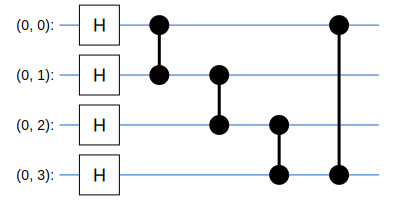

In [11]:
SVGCircuit(cluster_state_circuit(cirq.GridQubit.rect(1, 4)))

#### 1.5.2 QCNN レイヤー

<a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin の QCNN に関する論文</a>を使用して、モデルを構成するレイヤーを定義します。これには次の前提条件があります。

- <a href="https://arxiv.org/abs/quant-ph/0507171" class="external">Tucci の論文</a>にある 1 キュービットと 2 キュービットのパラメータ化されたユニタリ―行列
- 一般的なパラメータ化された 2 キュービットプーリング演算

In [12]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

作成したものを確認するために、1 キュービットのユニタリー回路を出力しましょう。

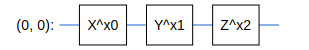

In [13]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

次に、2 キュービットのユニタリー回路を出力します。

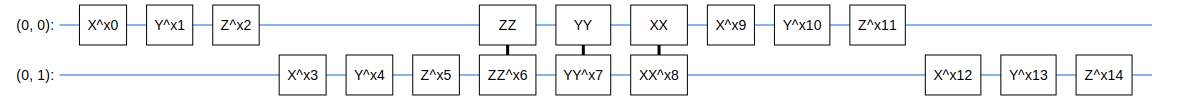

In [14]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

そして 2 キュービットのプーリング回路を出力します。

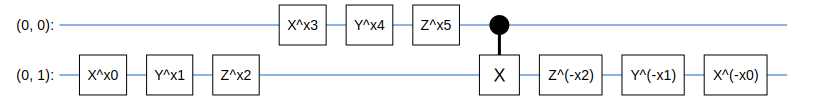

In [15]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

##### 1.5.2.1 量子畳み込み

<a href="https://arxiv.org/abs/1810.03787" class="external">Cong と Lukin</a> の論文にあるとおり、1 次元量子畳み込みを、ストライド 1 の隣接するすべてのキュービットペアに 2 キュービットのパラメーター化されたユニタリの適用として定義します。

In [16]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

（非常に水平な）回路を表示します。

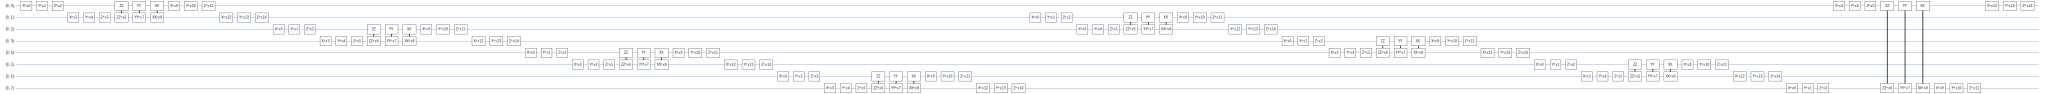

In [17]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

##### 1.5.2.2 量子プーリング

量子プーリングレイヤーは、上記で定義された 2 キュービットプールを使用して、$N$ キュービットから $\frac{N}{2}$ キュービットまでをプーリングします。

In [18]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

プーリングコンポーネント回路を調べます。

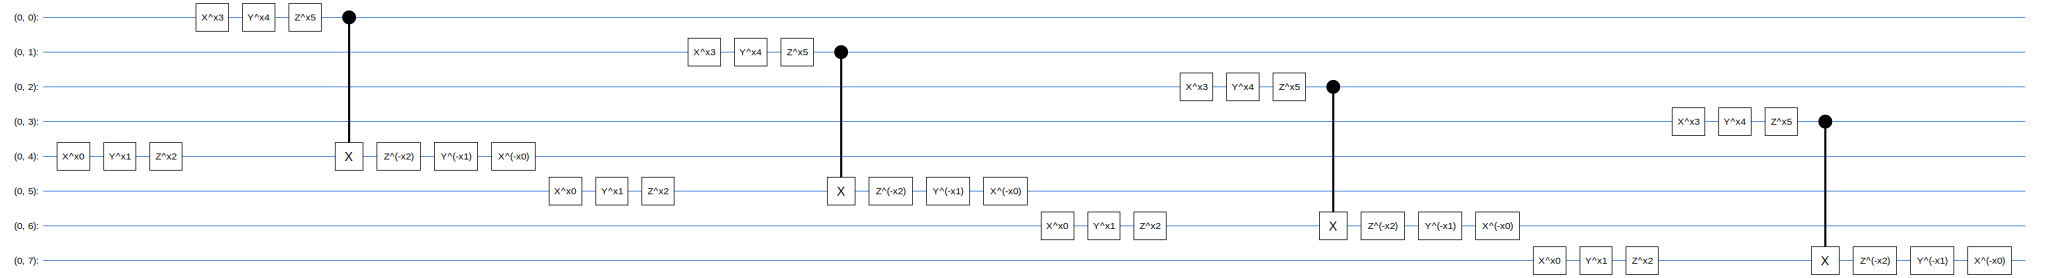

In [19]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

### 1.6 モデルの定義

定義したレイヤーを使用して純粋な量子 CNN を構築します。8 キュービットで開始し、1 キュービットまでプールダウンしてから、$\langle \hat{Z} \rangle$ を測定します。

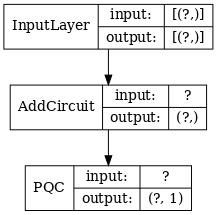

In [20]:
def create_model_circuit(qubits):
    """Create sequence of alternating convolution and pooling operators 
    which gradually shrink over time."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:63')
    # Cirq uses sympy.Symbols to map learnable variables. TensorFlow Quantum
    # scans incoming circuits and replaces these with TensorFlow variables.
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    model_circuit += quantum_conv_circuit(qubits[4:], symbols[21:36])
    model_circuit += quantum_pool_circuit(qubits[4:6], qubits[6:],
                                          symbols[36:42])
    model_circuit += quantum_conv_circuit(qubits[6:], symbols[42:57])
    model_circuit += quantum_pool_circuit([qubits[6]], [qubits[7]],
                                          symbols[57:63])
    return model_circuit


# Create our qubits and readout operators in Cirq.
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readout_operators = cirq.Z(cluster_state_bits[-1])

# Build a sequential model enacting the logic in 1.3 of this notebook.
# Here you are making the static cluster state prep as a part of the AddCircuit and the
# "quantum datapoints" are coming in the form of excitation
excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
cluster_state = tfq.layers.AddCircuit()(
    excitation_input, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model = tfq.layers.PQC(create_model_circuit(cluster_state_bits),
                               readout_operators)(cluster_state)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

### 1.7 モデルをトレーニングする

この例を単純化するために、完全なバッチでモデルをトレーニングします。

In [21]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    cluster_state_bits)


# Custom accuracy metric.
@tf.function
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25


1/7 [===>..........................] - ETA: 0s - loss: 1.0241 - custom_accuracy: 0.3750

2/7 [=======>......................] - ETA: 0s - loss: 0.9702 - custom_accuracy: 0.5625

3/7 [===========>..................] - ETA: 0s - loss: 0.9280 - custom_accuracy: 0.6875

4/7 [================>.............] - ETA: 0s - loss: 0.9006 - custom_accuracy: 0.7031

5/7 [====================>.........] - ETA: 0s - loss: 0.8976 - custom_accuracy: 0.7125

6/7 [========================>.....] - ETA: 0s - loss: 0.8820 - custom_accuracy: 0.7188

7/7 [==============================] - ETA: 0s - loss: 0.8843 - custom_accuracy: 0.6964

7/7 [==============================] - 1s 128ms/step - loss: 0.8843 - custom_accuracy: 0.6964 - val_loss: 0.7839 - val_custom_accuracy: 0.7083


Epoch 2/25
1/7 [===>..........................] - ETA: 0s - loss: 0.7370 - custom_accuracy: 0.7500

2/7 [=======>......................] - ETA: 0s - loss: 0.7900 - custom_accuracy: 0.7188

3/7 [===========>..................] - ETA: 0s - loss: 0.7955 - custom_accuracy: 0.7292

4/7 [================>.............] - ETA: 0s - loss: 0.8155 - custom_accuracy: 0.7031

5/7 [====================>.........] - ETA: 0s - loss: 0.8247 - custom_accuracy: 0.7125

6/7 [========================>.....] - ETA: 0s - loss: 0.8078 - custom_accuracy: 0.7396

7/7 [==============================] - ETA: 0s - loss: 0.7946 - custom_accuracy: 0.7411

7/7 [==============================] - 1s 102ms/step - loss: 0.7946 - custom_accuracy: 0.7411 - val_loss: 0.7767 - val_custom_accuracy: 0.7708


Epoch 3/25


1/7 [===>..........................] - ETA: 0s - loss: 0.7884 - custom_accuracy: 0.7500

2/7 [=======>......................] - ETA: 0s - loss: 0.7441 - custom_accuracy: 0.8438

3/7 [===========>..................] - ETA: 0s - loss: 0.7661 - custom_accuracy: 0.8125

4/7 [================>.............] - ETA: 0s - loss: 0.7615 - custom_accuracy: 0.7812

5/7 [====================>.........] - ETA: 0s - loss: 0.7428 - custom_accuracy: 0.8125

6/7 [========================>.....] - ETA: 0s - loss: 0.7329 - custom_accuracy: 0.8021

7/7 [==============================] - ETA: 0s - loss: 0.7505 - custom_accuracy: 0.7500

7/7 [==============================] - 1s 99ms/step - loss: 0.7505 - custom_accuracy: 0.7500 - val_loss: 0.7514 - val_custom_accuracy: 0.6458


Epoch 4/25


1/7 [===>..........................] - ETA: 0s - loss: 0.7118 - custom_accuracy: 0.8125

2/7 [=======>......................] - ETA: 0s - loss: 0.6394 - custom_accuracy: 0.8125

3/7 [===========>..................] - ETA: 0s - loss: 0.7539 - custom_accuracy: 0.6667

4/7 [================>.............] - ETA: 0s - loss: 0.7336 - custom_accuracy: 0.7188

5/7 [====================>.........] - ETA: 0s - loss: 0.7353 - custom_accuracy: 0.7375

6/7 [========================>.....] - ETA: 0s - loss: 0.7423 - custom_accuracy: 0.7396

7/7 [==============================] - ETA: 0s - loss: 0.7281 - custom_accuracy: 0.7589

7/7 [==============================] - 1s 96ms/step - loss: 0.7281 - custom_accuracy: 0.7589 - val_loss: 0.7199 - val_custom_accuracy: 0.8125


Epoch 5/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6460 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.6780 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.6812 - custom_accuracy: 0.8750

4/7 [================>.............] - ETA: 0s - loss: 0.6917 - custom_accuracy: 0.8906

5/7 [====================>.........] - ETA: 0s - loss: 0.6655 - custom_accuracy: 0.8750

6/7 [========================>.....] - ETA: 0s - loss: 0.6846 - custom_accuracy: 0.8438

7/7 [==============================] - ETA: 0s - loss: 0.7121 - custom_accuracy: 0.7946

7/7 [==============================] - 1s 96ms/step - loss: 0.7121 - custom_accuracy: 0.7946 - val_loss: 0.7120 - val_custom_accuracy: 0.8125


Epoch 6/25


1/7 [===>..........................] - ETA: 0s - loss: 0.8351 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.6859 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.7057 - custom_accuracy: 0.8750

4/7 [================>.............] - ETA: 0s - loss: 0.6944 - custom_accuracy: 0.8594

5/7 [====================>.........] - ETA: 0s - loss: 0.6981 - custom_accuracy: 0.8500

6/7 [========================>.....] - ETA: 0s - loss: 0.7095 - custom_accuracy: 0.8229

7/7 [==============================] - ETA: 0s - loss: 0.7066 - custom_accuracy: 0.8214

7/7 [==============================] - 1s 97ms/step - loss: 0.7066 - custom_accuracy: 0.8214 - val_loss: 0.7182 - val_custom_accuracy: 0.8125


Epoch 7/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6616 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.6461 - custom_accuracy: 0.9375

3/7 [===========>..................] - ETA: 0s - loss: 0.6648 - custom_accuracy: 0.8958

4/7 [================>.............] - ETA: 0s - loss: 0.6835 - custom_accuracy: 0.8906

5/7 [====================>.........] - ETA: 0s - loss: 0.6743 - custom_accuracy: 0.8875

6/7 [========================>.....] - ETA: 0s - loss: 0.6941 - custom_accuracy: 0.8542

7/7 [==============================] - ETA: 0s - loss: 0.6944 - custom_accuracy: 0.8393

7/7 [==============================] - 1s 94ms/step - loss: 0.6944 - custom_accuracy: 0.8393 - val_loss: 0.7058 - val_custom_accuracy: 0.8750


Epoch 8/25


1/7 [===>..........................] - ETA: 0s - loss: 0.7509 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.7358 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.7142 - custom_accuracy: 0.8958

4/7 [================>.............] - ETA: 0s - loss: 0.6816 - custom_accuracy: 0.9062

5/7 [====================>.........] - ETA: 0s - loss: 0.6755 - custom_accuracy: 0.9125

6/7 [========================>.....] - ETA: 0s - loss: 0.6936 - custom_accuracy: 0.8646

7/7 [==============================] - ETA: 0s - loss: 0.6940 - custom_accuracy: 0.8571

7/7 [==============================] - 1s 94ms/step - loss: 0.6940 - custom_accuracy: 0.8571 - val_loss: 0.7340 - val_custom_accuracy: 0.7708


Epoch 9/25


1/7 [===>..........................] - ETA: 0s - loss: 0.5917 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.6237 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.6853 - custom_accuracy: 0.8750

4/7 [================>.............] - ETA: 0s - loss: 0.6779 - custom_accuracy: 0.8750

5/7 [====================>.........] - ETA: 0s - loss: 0.6826 - custom_accuracy: 0.8875

6/7 [========================>.....] - ETA: 0s - loss: 0.6793 - custom_accuracy: 0.8958

7/7 [==============================] - ETA: 0s - loss: 0.6838 - custom_accuracy: 0.8929

7/7 [==============================] - 1s 95ms/step - loss: 0.6838 - custom_accuracy: 0.8929 - val_loss: 0.6876 - val_custom_accuracy: 0.8542


Epoch 10/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6888 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.6433 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.6548 - custom_accuracy: 0.8958

4/7 [================>.............] - ETA: 0s - loss: 0.6596 - custom_accuracy: 0.8750

5/7 [====================>.........] - ETA: 0s - loss: 0.6473 - custom_accuracy: 0.8875

6/7 [========================>.....] - ETA: 0s - loss: 0.6523 - custom_accuracy: 0.8854

7/7 [==============================] - ETA: 0s - loss: 0.6459 - custom_accuracy: 0.8839

7/7 [==============================] - 1s 94ms/step - loss: 0.6459 - custom_accuracy: 0.8839 - val_loss: 0.6538 - val_custom_accuracy: 0.8125


Epoch 11/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6527 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.6226 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.6292 - custom_accuracy: 0.8542

4/7 [================>.............] - ETA: 0s - loss: 0.6307 - custom_accuracy: 0.8438

5/7 [====================>.........] - ETA: 0s - loss: 0.6060 - custom_accuracy: 0.8500

6/7 [========================>.....] - ETA: 0s - loss: 0.6036 - custom_accuracy: 0.8542

7/7 [==============================] - ETA: 0s - loss: 0.5875 - custom_accuracy: 0.8750

7/7 [==============================] - 1s 95ms/step - loss: 0.5875 - custom_accuracy: 0.8750 - val_loss: 0.6134 - val_custom_accuracy: 0.8125


Epoch 12/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6732 - custom_accuracy: 0.8125

2/7 [=======>......................] - ETA: 0s - loss: 0.6320 - custom_accuracy: 0.8125

3/7 [===========>..................] - ETA: 0s - loss: 0.5802 - custom_accuracy: 0.8333

4/7 [================>.............] - ETA: 0s - loss: 0.5890 - custom_accuracy: 0.7969

5/7 [====================>.........] - ETA: 0s - loss: 0.5621 - custom_accuracy: 0.8125

6/7 [========================>.....] - ETA: 0s - loss: 0.5372 - custom_accuracy: 0.8125

7/7 [==============================] - ETA: 0s - loss: 0.5375 - custom_accuracy: 0.8125

7/7 [==============================] - 1s 92ms/step - loss: 0.5375 - custom_accuracy: 0.8125 - val_loss: 0.5855 - val_custom_accuracy: 0.6667


Epoch 13/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3784 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.3910 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.5150 - custom_accuracy: 0.8333

4/7 [================>.............] - ETA: 0s - loss: 0.5146 - custom_accuracy: 0.7969

5/7 [====================>.........] - ETA: 0s - loss: 0.4990 - custom_accuracy: 0.8125

6/7 [========================>.....] - ETA: 0s - loss: 0.5145 - custom_accuracy: 0.7917

7/7 [==============================] - ETA: 0s - loss: 0.5062 - custom_accuracy: 0.8036

7/7 [==============================] - 1s 89ms/step - loss: 0.5062 - custom_accuracy: 0.8036 - val_loss: 0.5798 - val_custom_accuracy: 0.7083


Epoch 14/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2510 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.3909 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.4768 - custom_accuracy: 0.8333

4/7 [================>.............] - ETA: 0s - loss: 0.5438 - custom_accuracy: 0.8125

5/7 [====================>.........] - ETA: 0s - loss: 0.5077 - custom_accuracy: 0.8375

6/7 [========================>.....] - ETA: 0s - loss: 0.5144 - custom_accuracy: 0.8333

7/7 [==============================] - ETA: 0s - loss: 0.5071 - custom_accuracy: 0.8304

7/7 [==============================] - 1s 89ms/step - loss: 0.5071 - custom_accuracy: 0.8304 - val_loss: 0.5781 - val_custom_accuracy: 0.7292


Epoch 15/25


1/7 [===>..........................] - ETA: 0s - loss: 0.5155 - custom_accuracy: 0.7500

2/7 [=======>......................] - ETA: 0s - loss: 0.5062 - custom_accuracy: 0.7500

3/7 [===========>..................] - ETA: 0s - loss: 0.5492 - custom_accuracy: 0.7083

4/7 [================>.............] - ETA: 0s - loss: 0.5224 - custom_accuracy: 0.7656

5/7 [====================>.........] - ETA: 0s - loss: 0.5402 - custom_accuracy: 0.7750

6/7 [========================>.....] - ETA: 0s - loss: 0.5365 - custom_accuracy: 0.7812

7/7 [==============================] - ETA: 0s - loss: 0.5062 - custom_accuracy: 0.8036

7/7 [==============================] - 1s 91ms/step - loss: 0.5062 - custom_accuracy: 0.8036 - val_loss: 0.5772 - val_custom_accuracy: 0.6875


Epoch 16/25


1/7 [===>..........................] - ETA: 0s - loss: 0.6913 - custom_accuracy: 0.6250

2/7 [=======>......................] - ETA: 0s - loss: 0.5586 - custom_accuracy: 0.7188

3/7 [===========>..................] - ETA: 0s - loss: 0.5804 - custom_accuracy: 0.7083

4/7 [================>.............] - ETA: 0s - loss: 0.5448 - custom_accuracy: 0.7500

5/7 [====================>.........] - ETA: 0s - loss: 0.5433 - custom_accuracy: 0.7500

6/7 [========================>.....] - ETA: 0s - loss: 0.5094 - custom_accuracy: 0.7812

7/7 [==============================] - ETA: 0s - loss: 0.5037 - custom_accuracy: 0.7857

7/7 [==============================] - 1s 91ms/step - loss: 0.5037 - custom_accuracy: 0.7857 - val_loss: 0.5751 - val_custom_accuracy: 0.6875


Epoch 17/25


1/7 [===>..........................] - ETA: 0s - loss: 0.4890 - custom_accuracy: 0.8125

2/7 [=======>......................] - ETA: 0s - loss: 0.3937 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.4668 - custom_accuracy: 0.8125

4/7 [================>.............] - ETA: 0s - loss: 0.5052 - custom_accuracy: 0.7656

5/7 [====================>.........] - ETA: 0s - loss: 0.4916 - custom_accuracy: 0.7625

6/7 [========================>.....] - ETA: 0s - loss: 0.5143 - custom_accuracy: 0.7708

7/7 [==============================] - ETA: 0s - loss: 0.4947 - custom_accuracy: 0.7768

7/7 [==============================] - 1s 91ms/step - loss: 0.4947 - custom_accuracy: 0.7768 - val_loss: 0.5747 - val_custom_accuracy: 0.7083


Epoch 18/25


1/7 [===>..........................] - ETA: 0s - loss: 0.5025 - custom_accuracy: 0.6875

2/7 [=======>......................] - ETA: 0s - loss: 0.5385 - custom_accuracy: 0.7500

3/7 [===========>..................] - ETA: 0s - loss: 0.5120 - custom_accuracy: 0.7500

4/7 [================>.............] - ETA: 0s - loss: 0.5424 - custom_accuracy: 0.7188

5/7 [====================>.........] - ETA: 0s - loss: 0.5066 - custom_accuracy: 0.7500

6/7 [========================>.....] - ETA: 0s - loss: 0.5020 - custom_accuracy: 0.7708

7/7 [==============================] - ETA: 0s - loss: 0.4875 - custom_accuracy: 0.7768

7/7 [==============================] - 1s 90ms/step - loss: 0.4875 - custom_accuracy: 0.7768 - val_loss: 0.5717 - val_custom_accuracy: 0.6667


Epoch 19/25


1/7 [===>..........................] - ETA: 0s - loss: 0.5504 - custom_accuracy: 0.6250

2/7 [=======>......................] - ETA: 0s - loss: 0.5274 - custom_accuracy: 0.7500

3/7 [===========>..................] - ETA: 0s - loss: 0.4934 - custom_accuracy: 0.7917

4/7 [================>.............] - ETA: 0s - loss: 0.4966 - custom_accuracy: 0.7969

5/7 [====================>.........] - ETA: 0s - loss: 0.4991 - custom_accuracy: 0.8125

6/7 [========================>.....] - ETA: 0s - loss: 0.5132 - custom_accuracy: 0.8125

7/7 [==============================] - ETA: 0s - loss: 0.5015 - custom_accuracy: 0.8125

7/7 [==============================] - 1s 92ms/step - loss: 0.5015 - custom_accuracy: 0.8125 - val_loss: 0.5885 - val_custom_accuracy: 0.7292


Epoch 20/25


1/7 [===>..........................] - ETA: 0s - loss: 0.8050 - custom_accuracy: 0.6250

2/7 [=======>......................] - ETA: 0s - loss: 0.5872 - custom_accuracy: 0.7188

3/7 [===========>..................] - ETA: 0s - loss: 0.4749 - custom_accuracy: 0.8125

4/7 [================>.............] - ETA: 0s - loss: 0.5145 - custom_accuracy: 0.8281

5/7 [====================>.........] - ETA: 0s - loss: 0.5008 - custom_accuracy: 0.8250

6/7 [========================>.....] - ETA: 0s - loss: 0.4870 - custom_accuracy: 0.8333

7/7 [==============================] - ETA: 0s - loss: 0.4941 - custom_accuracy: 0.8036

7/7 [==============================] - 1s 90ms/step - loss: 0.4941 - custom_accuracy: 0.8036 - val_loss: 0.5765 - val_custom_accuracy: 0.6875


Epoch 21/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3940 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.4719 - custom_accuracy: 0.8438

3/7 [===========>..................] - ETA: 0s - loss: 0.4793 - custom_accuracy: 0.8333

4/7 [================>.............] - ETA: 0s - loss: 0.4956 - custom_accuracy: 0.8125

5/7 [====================>.........] - ETA: 0s - loss: 0.4716 - custom_accuracy: 0.8250

6/7 [========================>.....] - ETA: 0s - loss: 0.4888 - custom_accuracy: 0.8021

7/7 [==============================] - ETA: 0s - loss: 0.4830 - custom_accuracy: 0.8036

7/7 [==============================] - 1s 90ms/step - loss: 0.4830 - custom_accuracy: 0.8036 - val_loss: 0.5753 - val_custom_accuracy: 0.7500


Epoch 22/25


1/7 [===>..........................] - ETA: 0s - loss: 0.5142 - custom_accuracy: 0.8125

2/7 [=======>......................] - ETA: 0s - loss: 0.4577 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.5441 - custom_accuracy: 0.7917

4/7 [================>.............] - ETA: 0s - loss: 0.5359 - custom_accuracy: 0.8281

5/7 [====================>.........] - ETA: 0s - loss: 0.5192 - custom_accuracy: 0.8250

6/7 [========================>.....] - ETA: 0s - loss: 0.5166 - custom_accuracy: 0.8021

7/7 [==============================] - ETA: 0s - loss: 0.4861 - custom_accuracy: 0.8125

7/7 [==============================] - 1s 88ms/step - loss: 0.4861 - custom_accuracy: 0.8125 - val_loss: 0.5649 - val_custom_accuracy: 0.7292


Epoch 23/25


1/7 [===>..........................] - ETA: 0s - loss: 0.7284 - custom_accuracy: 0.6875

2/7 [=======>......................] - ETA: 0s - loss: 0.6020 - custom_accuracy: 0.7812

3/7 [===========>..................] - ETA: 0s - loss: 0.5171 - custom_accuracy: 0.8125

4/7 [================>.............] - ETA: 0s - loss: 0.4701 - custom_accuracy: 0.8438

5/7 [====================>.........] - ETA: 0s - loss: 0.5220 - custom_accuracy: 0.8000

6/7 [========================>.....] - ETA: 0s - loss: 0.5146 - custom_accuracy: 0.8125

7/7 [==============================] - ETA: 0s - loss: 0.4845 - custom_accuracy: 0.8304

7/7 [==============================] - 1s 89ms/step - loss: 0.4845 - custom_accuracy: 0.8304 - val_loss: 0.5788 - val_custom_accuracy: 0.7292


Epoch 24/25


1/7 [===>..........................] - ETA: 0s - loss: 0.7848 - custom_accuracy: 0.5625

2/7 [=======>......................] - ETA: 0s - loss: 0.5793 - custom_accuracy: 0.7188

3/7 [===========>..................] - ETA: 0s - loss: 0.5894 - custom_accuracy: 0.7708

4/7 [================>.............] - ETA: 0s - loss: 0.5304 - custom_accuracy: 0.7969

5/7 [====================>.........] - ETA: 0s - loss: 0.4583 - custom_accuracy: 0.8375

6/7 [========================>.....] - ETA: 0s - loss: 0.4782 - custom_accuracy: 0.8125

7/7 [==============================] - ETA: 0s - loss: 0.5024 - custom_accuracy: 0.7946

7/7 [==============================] - 1s 93ms/step - loss: 0.5024 - custom_accuracy: 0.7946 - val_loss: 0.5973 - val_custom_accuracy: 0.6667


Epoch 25/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3908 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.4747 - custom_accuracy: 0.8125

3/7 [===========>..................] - ETA: 0s - loss: 0.4610 - custom_accuracy: 0.7917

4/7 [================>.............] - ETA: 0s - loss: 0.4659 - custom_accuracy: 0.7812

5/7 [====================>.........] - ETA: 0s - loss: 0.4739 - custom_accuracy: 0.7875

6/7 [========================>.....] - ETA: 0s - loss: 0.5169 - custom_accuracy: 0.7917

7/7 [==============================] - ETA: 0s - loss: 0.5012 - custom_accuracy: 0.8036

7/7 [==============================] - 1s 90ms/step - loss: 0.5012 - custom_accuracy: 0.8036 - val_loss: 0.5942 - val_custom_accuracy: 0.7500


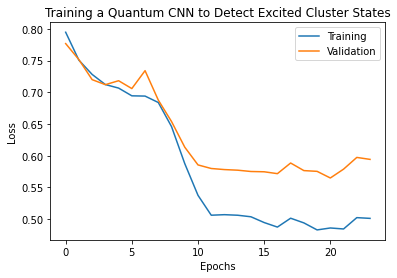

In [22]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Training a Quantum CNN to Detect Excited Cluster States')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 2. ハイブリッドモデル

量子畳み込みを使用して 8 キュービットから 1 キュービットにする必要はありません。量子畳み込みの 1～2 ラウンドを実行し、結果を従来のニューラルネットワークにフィードすることも可能です。このセクションでは、量子と従来のハイブリッドモデルを説明します。

### 2.1 単一量子フィルタを備えたハイブリッドモデル

量子畳み込みのレイヤーを 1 つ適用し、すべてのビットの $\langle \hat{Z}_n \rangle$ を読み取り、続いて密に接続されたニューラルネットワークを読み取ります。

<img src="./images/qcnn_5.png" width="1000">

#### 2.1.1 モデルの定義

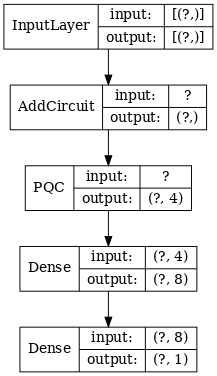

In [23]:
# 1-local operators to read out
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
                                          symbols[15:21])
    return model_circuit


# Build a model enacting the logic in 2.1 of this notebook.
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])

# Display the model architecture
tf.keras.utils.plot_model(hybrid_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

#### 2.1.2 モデルをトレーニングする

In [24]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=[custom_accuracy])

hybrid_history = hybrid_model.fit(x=train_excitations,
                                  y=train_labels,
                                  batch_size=16,
                                  epochs=25,
                                  verbose=1,
                                  validation_data=(test_excitations,
                                                   test_labels))

Epoch 1/25


1/7 [===>..........................] - ETA: 0s - loss: 0.9772 - custom_accuracy: 0.6875

2/7 [=======>......................] - ETA: 0s - loss: 0.9212 - custom_accuracy: 0.7500

4/7 [================>.............] - ETA: 0s - loss: 0.8437 - custom_accuracy: 0.7500

5/7 [====================>.........] - ETA: 0s - loss: 0.8697 - custom_accuracy: 0.6875

6/7 [========================>.....] - ETA: 0s - loss: 0.8333 - custom_accuracy: 0.6875

7/7 [==============================] - ETA: 0s - loss: 0.8001 - custom_accuracy: 0.7054

7/7 [==============================] - 1s 77ms/step - loss: 0.8001 - custom_accuracy: 0.7054 - val_loss: 0.3556 - val_custom_accuracy: 0.9375


Epoch 2/25
1/7 [===>..........................] - ETA: 0s - loss: 0.4617 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.3599 - custom_accuracy: 0.9167

4/7 [================>.............] - ETA: 0s - loss: 0.3324 - custom_accuracy: 0.9375

5/7 [====================>.........] - ETA: 0s - loss: 0.3569 - custom_accuracy: 0.9125

7/7 [==============================] - ETA: 0s - loss: 0.3298 - custom_accuracy: 0.9286

7/7 [==============================] - 0s 57ms/step - loss: 0.3298 - custom_accuracy: 0.9286 - val_loss: 0.2516 - val_custom_accuracy: 0.9375


Epoch 3/25
1/7 [===>..........................] - ETA: 0s - loss: 0.3547 - custom_accuracy: 0.8750

3/7 [===========>..................] - ETA: 0s - loss: 0.4063 - custom_accuracy: 0.8958

4/7 [================>.............] - ETA: 0s - loss: 0.3383 - custom_accuracy: 0.9219

5/7 [====================>.........] - ETA: 0s - loss: 0.3276 - custom_accuracy: 0.9375

7/7 [==============================] - ETA: 0s - loss: 0.2807 - custom_accuracy: 0.9554

7/7 [==============================] - 0s 57ms/step - loss: 0.2807 - custom_accuracy: 0.9554 - val_loss: 0.2546 - val_custom_accuracy: 0.9792


Epoch 4/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1911 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2314 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.2131 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2327 - custom_accuracy: 0.9875

7/7 [==============================] - ETA: 0s - loss: 0.2420 - custom_accuracy: 0.9821

7/7 [==============================] - 0s 57ms/step - loss: 0.2420 - custom_accuracy: 0.9821 - val_loss: 0.1967 - val_custom_accuracy: 0.9792


Epoch 5/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1280 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1584 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1995 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.2144 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.2114 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.2088 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 59ms/step - loss: 0.2088 - custom_accuracy: 1.0000 - val_loss: 0.1852 - val_custom_accuracy: 0.9792


Epoch 6/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2056 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2043 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.2234 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.2152 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1918 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.2045 - custom_accuracy: 0.9911

7/7 [==============================] - 0s 59ms/step - loss: 0.2045 - custom_accuracy: 0.9911 - val_loss: 0.1840 - val_custom_accuracy: 0.9792


Epoch 7/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1599 - custom_accuracy: 0.9375

3/7 [===========>..................] - ETA: 0s - loss: 0.2425 - custom_accuracy: 0.9167

4/7 [================>.............] - ETA: 0s - loss: 0.2336 - custom_accuracy: 0.9375

5/7 [====================>.........] - ETA: 0s - loss: 0.2254 - custom_accuracy: 0.9500

7/7 [==============================] - ETA: 0s - loss: 0.2087 - custom_accuracy: 0.9554

7/7 [==============================] - 0s 57ms/step - loss: 0.2087 - custom_accuracy: 0.9554 - val_loss: 0.1889 - val_custom_accuracy: 0.9792


Epoch 8/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1001 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1837 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.2023 - custom_accuracy: 0.9875

7/7 [==============================] - ETA: 0s - loss: 0.2055 - custom_accuracy: 0.9821

7/7 [==============================] - 0s 55ms/step - loss: 0.2055 - custom_accuracy: 0.9821 - val_loss: 0.1970 - val_custom_accuracy: 1.0000


Epoch 9/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3407 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2642 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.2394 - custom_accuracy: 0.9844

6/7 [========================>.....] - ETA: 0s - loss: 0.2156 - custom_accuracy: 0.9896

7/7 [==============================] - 0s 55ms/step - loss: 0.2078 - custom_accuracy: 0.9911 - val_loss: 0.1835 - val_custom_accuracy: 1.0000


Epoch 10/25
1/7 [===>..........................] - ETA: 0s - loss: 0.0992 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1548 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1872 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2032 - custom_accuracy: 0.9875

7/7 [==============================] - ETA: 0s - loss: 0.1962 - custom_accuracy: 0.9911

7/7 [==============================] - 0s 57ms/step - loss: 0.1962 - custom_accuracy: 0.9911 - val_loss: 0.1787 - val_custom_accuracy: 1.0000


Epoch 11/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1397 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1535 - custom_accuracy: 0.9792

5/7 [====================>.........] - ETA: 0s - loss: 0.1543 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1855 - custom_accuracy: 0.9896

7/7 [==============================] - 0s 56ms/step - loss: 0.1884 - custom_accuracy: 0.9911 - val_loss: 0.1884 - val_custom_accuracy: 1.0000


Epoch 12/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1558 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2014 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.2013 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1871 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 55ms/step - loss: 0.1871 - custom_accuracy: 1.0000 - val_loss: 0.1869 - val_custom_accuracy: 1.0000


Epoch 13/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2298 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1738 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1866 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1667 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1767 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1854 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 59ms/step - loss: 0.1854 - custom_accuracy: 1.0000 - val_loss: 0.1799 - val_custom_accuracy: 1.0000


Epoch 14/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2301 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2261 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2206 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1980 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1898 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1881 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 58ms/step - loss: 0.1881 - custom_accuracy: 1.0000 - val_loss: 0.1824 - val_custom_accuracy: 1.0000


Epoch 15/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1370 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2075 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.1902 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.2011 - custom_accuracy: 0.9750

7/7 [==============================] - ETA: 0s - loss: 0.1965 - custom_accuracy: 0.9821

7/7 [==============================] - 0s 58ms/step - loss: 0.1965 - custom_accuracy: 0.9821 - val_loss: 0.1733 - val_custom_accuracy: 1.0000


Epoch 16/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1972 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1564 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1726 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1682 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 56ms/step - loss: 0.1884 - custom_accuracy: 1.0000 - val_loss: 0.1768 - val_custom_accuracy: 1.0000


Epoch 17/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1895 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1657 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1984 - custom_accuracy: 0.9792

5/7 [====================>.........] - ETA: 0s - loss: 0.2101 - custom_accuracy: 0.9625

6/7 [========================>.....] - ETA: 0s - loss: 0.2008 - custom_accuracy: 0.9688

7/7 [==============================] - ETA: 0s - loss: 0.1948 - custom_accuracy: 0.9732

7/7 [==============================] - 0s 58ms/step - loss: 0.1948 - custom_accuracy: 0.9732 - val_loss: 0.1831 - val_custom_accuracy: 1.0000


Epoch 18/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1280 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1920 - custom_accuracy: 0.9688

4/7 [================>.............] - ETA: 0s - loss: 0.2088 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.2107 - custom_accuracy: 0.9625

7/7 [==============================] - ETA: 0s - loss: 0.1937 - custom_accuracy: 0.9732

7/7 [==============================] - 0s 58ms/step - loss: 0.1937 - custom_accuracy: 0.9732 - val_loss: 0.1869 - val_custom_accuracy: 1.0000


Epoch 19/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1314 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1686 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1976 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.1679 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1845 - custom_accuracy: 0.9750

7/7 [==============================] - ETA: 0s - loss: 0.1928 - custom_accuracy: 0.9732

7/7 [==============================] - 0s 59ms/step - loss: 0.1928 - custom_accuracy: 0.9732 - val_loss: 0.1818 - val_custom_accuracy: 1.0000


Epoch 20/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1365 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1905 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1819 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1782 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1972 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1878 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 59ms/step - loss: 0.1878 - custom_accuracy: 1.0000 - val_loss: 0.1687 - val_custom_accuracy: 1.0000


Epoch 21/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1512 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1524 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1673 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1765 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1869 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1786 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1884 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 61ms/step - loss: 0.1884 - custom_accuracy: 1.0000 - val_loss: 0.1760 - val_custom_accuracy: 1.0000


Epoch 22/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1787 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2078 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1873 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.1776 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1748 - custom_accuracy: 0.9750

7/7 [==============================] - ETA: 0s - loss: 0.1809 - custom_accuracy: 0.9821

7/7 [==============================] - 0s 59ms/step - loss: 0.1809 - custom_accuracy: 0.9821 - val_loss: 0.1965 - val_custom_accuracy: 1.0000


Epoch 23/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1690 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1791 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1937 - custom_accuracy: 0.9844

6/7 [========================>.....] - ETA: 0s - loss: 0.1811 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1880 - custom_accuracy: 0.9911

7/7 [==============================] - 0s 59ms/step - loss: 0.1880 - custom_accuracy: 0.9911 - val_loss: 0.1738 - val_custom_accuracy: 1.0000


Epoch 24/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2381 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1703 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1916 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.2043 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1991 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1840 - custom_accuracy: 1.0000

7/7 [==============================] - ETA: 0s - loss: 0.1901 - custom_accuracy: 1.0000

7/7 [==============================] - 0s 59ms/step - loss: 0.1901 - custom_accuracy: 1.0000 - val_loss: 0.1879 - val_custom_accuracy: 1.0000


Epoch 25/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2196 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2231 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2186 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1992 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1911 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1874 - custom_accuracy: 0.9821

7/7 [==============================] - 0s 59ms/step - loss: 0.1874 - custom_accuracy: 0.9821 - val_loss: 0.1845 - val_custom_accuracy: 1.0000


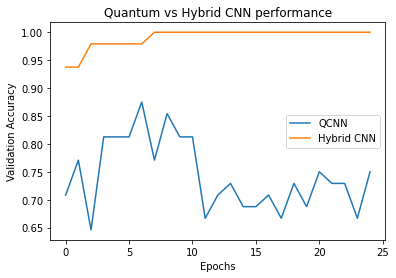

In [25]:
plt.plot(history.history['val_custom_accuracy'], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'], label='Hybrid CNN')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()

ご覧のとおり、非常に控えめな古典的支援により、ハイブリッドモデルは通常、純粋な量子バージョンよりも速く収束します。

### 2.2 多重量子フィルタを備えたハイブリッド畳み込み

多重量子畳み込みと従来のニューラルネットワークを使用してそれらを組み合わせるアーキテクチャを試してみましょう。

<img src="./images/qcnn_6.png" width="1000">

#### 2.2.1 モデルの定義

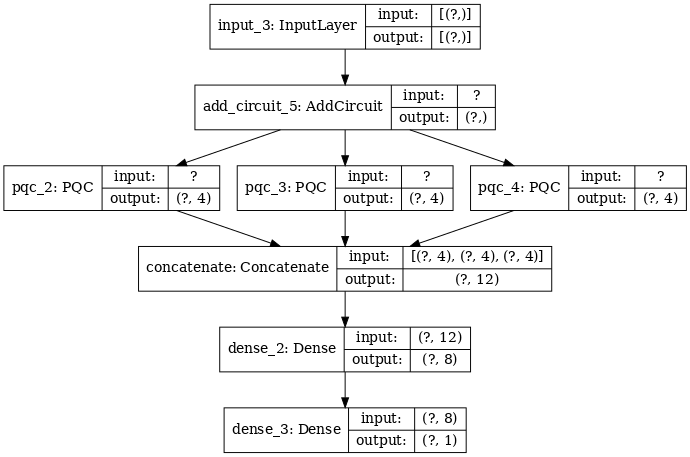

In [26]:
excitation_input_multi = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_multi = tfq.layers.AddCircuit()(
    excitation_input_multi, prepend=cluster_state_circuit(cluster_state_bits))

# apply 3 different filters and measure expectation values

quantum_model_multi1 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi2 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

quantum_model_multi3 = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_multi)

# concatenate outputs and feed into a small classical NN
concat_out = tf.keras.layers.concatenate(
    [quantum_model_multi1, quantum_model_multi2, quantum_model_multi3])

dense_1 = tf.keras.layers.Dense(8)(concat_out)

dense_2 = tf.keras.layers.Dense(1)(dense_1)

multi_qconv_model = tf.keras.Model(inputs=[excitation_input_multi],
                                   outputs=[dense_2])

# Display the model architecture
tf.keras.utils.plot_model(multi_qconv_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

#### 2.2.2 モデルをトレーニングする

In [27]:
multi_qconv_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
    loss=tf.losses.mse,
    metrics=[custom_accuracy])

multi_qconv_history = multi_qconv_model.fit(x=train_excitations,
                                            y=train_labels,
                                            batch_size=16,
                                            epochs=25,
                                            verbose=1,
                                            validation_data=(test_excitations,
                                                             test_labels))

Epoch 1/25


1/7 [===>..........................] - ETA: 0s - loss: 0.9337 - custom_accuracy: 0.6250

2/7 [=======>......................] - ETA: 0s - loss: 0.8992 - custom_accuracy: 0.6250

3/7 [===========>..................] - ETA: 0s - loss: 0.9043 - custom_accuracy: 0.5833

4/7 [================>.............] - ETA: 0s - loss: 0.8659 - custom_accuracy: 0.6406

5/7 [====================>.........] - ETA: 0s - loss: 0.8198 - custom_accuracy: 0.7000

6/7 [========================>.....] - ETA: 0s - loss: 0.7945 - custom_accuracy: 0.7396

7/7 [==============================] - ETA: 0s - loss: 0.7519 - custom_accuracy: 0.7679

7/7 [==============================] - 1s 110ms/step - loss: 0.7519 - custom_accuracy: 0.7679 - val_loss: 0.5226 - val_custom_accuracy: 0.8750


Epoch 2/25
1/7 [===>..........................] - ETA: 0s - loss: 0.5907 - custom_accuracy: 0.8125

2/7 [=======>......................] - ETA: 0s - loss: 0.4515 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.4022 - custom_accuracy: 0.9167

4/7 [================>.............] - ETA: 0s - loss: 0.3632 - custom_accuracy: 0.9375

5/7 [====================>.........] - ETA: 0s - loss: 0.3766 - custom_accuracy: 0.9250

6/7 [========================>.....] - ETA: 0s - loss: 0.3462 - custom_accuracy: 0.9271

7/7 [==============================] - ETA: 0s - loss: 0.3448 - custom_accuracy: 0.9286

7/7 [==============================] - 1s 84ms/step - loss: 0.3448 - custom_accuracy: 0.9286 - val_loss: 0.2624 - val_custom_accuracy: 0.9792


Epoch 3/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2140 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.2770 - custom_accuracy: 0.9062

3/7 [===========>..................] - ETA: 0s - loss: 0.2602 - custom_accuracy: 0.9375

4/7 [================>.............] - ETA: 0s - loss: 0.3001 - custom_accuracy: 0.9219

5/7 [====================>.........] - ETA: 0s - loss: 0.2837 - custom_accuracy: 0.9375

6/7 [========================>.....] - ETA: 0s - loss: 0.2728 - custom_accuracy: 0.9271

7/7 [==============================] - ETA: 0s - loss: 0.2618 - custom_accuracy: 0.9375

7/7 [==============================] - 1s 84ms/step - loss: 0.2618 - custom_accuracy: 0.9375 - val_loss: 0.2998 - val_custom_accuracy: 0.9375


Epoch 4/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3412 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.3150 - custom_accuracy: 0.9375

3/7 [===========>..................] - ETA: 0s - loss: 0.2873 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.2524 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.2527 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.2391 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.2450 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 83ms/step - loss: 0.2450 - custom_accuracy: 0.9732 - val_loss: 0.2298 - val_custom_accuracy: 0.9792


Epoch 5/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1371 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1675 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1840 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1799 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1947 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.2034 - custom_accuracy: 0.9688

7/7 [==============================] - ETA: 0s - loss: 0.2133 - custom_accuracy: 0.9554

7/7 [==============================] - 1s 77ms/step - loss: 0.2133 - custom_accuracy: 0.9554 - val_loss: 0.2444 - val_custom_accuracy: 0.9375


Epoch 6/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2209 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.2132 - custom_accuracy: 0.9375

3/7 [===========>..................] - ETA: 0s - loss: 0.2267 - custom_accuracy: 0.9375

4/7 [================>.............] - ETA: 0s - loss: 0.2160 - custom_accuracy: 0.9531

5/7 [====================>.........] - ETA: 0s - loss: 0.2206 - custom_accuracy: 0.9500

6/7 [========================>.....] - ETA: 0s - loss: 0.2108 - custom_accuracy: 0.9583

7/7 [==============================] - ETA: 0s - loss: 0.2018 - custom_accuracy: 0.9643

7/7 [==============================] - 1s 79ms/step - loss: 0.2018 - custom_accuracy: 0.9643 - val_loss: 0.2128 - val_custom_accuracy: 0.9792


Epoch 7/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2504 - custom_accuracy: 0.9375

2/7 [=======>......................] - ETA: 0s - loss: 0.1864 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1842 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1766 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1736 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1929 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1994 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 88ms/step - loss: 0.1994 - custom_accuracy: 0.9821 - val_loss: 0.1889 - val_custom_accuracy: 0.9583


Epoch 8/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1156 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1802 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1673 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1549 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1998 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.2059 - custom_accuracy: 0.9688

7/7 [==============================] - ETA: 0s - loss: 0.2024 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 82ms/step - loss: 0.2024 - custom_accuracy: 0.9732 - val_loss: 0.2196 - val_custom_accuracy: 0.9583


Epoch 9/25
1/7 [===>..........................] - ETA: 0s - loss: 0.1167 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1444 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1630 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1744 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1819 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1749 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1967 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 82ms/step - loss: 0.1967 - custom_accuracy: 0.9732 - val_loss: 0.2129 - val_custom_accuracy: 1.0000


Epoch 10/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1081 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1484 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1800 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1681 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2038 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.2072 - custom_accuracy: 0.9688

7/7 [==============================] - ETA: 0s - loss: 0.1952 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 80ms/step - loss: 0.1952 - custom_accuracy: 0.9732 - val_loss: 0.1964 - val_custom_accuracy: 1.0000


Epoch 11/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2036 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1786 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1857 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1771 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1713 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1812 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1945 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 81ms/step - loss: 0.1945 - custom_accuracy: 0.9821 - val_loss: 0.1918 - val_custom_accuracy: 0.9792


Epoch 12/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1943 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1987 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.2184 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.2171 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2044 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1982 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1890 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 79ms/step - loss: 0.1890 - custom_accuracy: 0.9821 - val_loss: 0.2117 - val_custom_accuracy: 0.9583


Epoch 13/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1213 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1569 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1690 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1522 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1500 - custom_accuracy: 1.0000

6/7 [========================>.....] - ETA: 0s - loss: 0.1865 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1891 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 81ms/step - loss: 0.1891 - custom_accuracy: 0.9821 - val_loss: 0.2201 - val_custom_accuracy: 0.9375


Epoch 14/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1654 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1962 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1864 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1917 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2060 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.2052 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1936 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 84ms/step - loss: 0.1936 - custom_accuracy: 0.9821 - val_loss: 0.2184 - val_custom_accuracy: 0.9792


Epoch 15/25


1/7 [===>..........................] - ETA: 0s - loss: 0.0942 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1395 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2099 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.2021 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2012 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1983 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.2028 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 82ms/step - loss: 0.2028 - custom_accuracy: 0.9821 - val_loss: 0.2323 - val_custom_accuracy: 0.9792


Epoch 16/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1194 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1585 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1454 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1816 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1882 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.2042 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.2221 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 79ms/step - loss: 0.2221 - custom_accuracy: 0.9732 - val_loss: 0.2088 - val_custom_accuracy: 0.9792


Epoch 17/25


1/7 [===>..........................] - ETA: 0s - loss: 0.2117 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2424 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.2504 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.2406 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.2270 - custom_accuracy: 0.9625

6/7 [========================>.....] - ETA: 0s - loss: 0.2263 - custom_accuracy: 0.9583

7/7 [==============================] - ETA: 0s - loss: 0.2225 - custom_accuracy: 0.9554

7/7 [==============================] - 1s 83ms/step - loss: 0.2225 - custom_accuracy: 0.9554 - val_loss: 0.1994 - val_custom_accuracy: 0.9583


Epoch 18/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1784 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1655 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1867 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1693 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1862 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1743 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1849 - custom_accuracy: 0.9732

7/7 [==============================] - 1s 83ms/step - loss: 0.1849 - custom_accuracy: 0.9732 - val_loss: 0.1880 - val_custom_accuracy: 0.9792


Epoch 19/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1812 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2067 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1888 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1906 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1850 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1721 - custom_accuracy: 0.9896

7/7 [==============================] - ETA: 0s - loss: 0.1919 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 82ms/step - loss: 0.1919 - custom_accuracy: 0.9821 - val_loss: 0.1857 - val_custom_accuracy: 1.0000


Epoch 20/25


1/7 [===>..........................] - ETA: 0s - loss: 0.0390 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1129 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1471 - custom_accuracy: 1.0000

4/7 [================>.............] - ETA: 0s - loss: 0.1656 - custom_accuracy: 1.0000

5/7 [====================>.........] - ETA: 0s - loss: 0.1923 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.2017 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1907 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 79ms/step - loss: 0.1907 - custom_accuracy: 0.9821 - val_loss: 0.2216 - val_custom_accuracy: 0.9792


Epoch 21/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1839 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1832 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.2262 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.2114 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.2155 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1994 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1929 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 82ms/step - loss: 0.1929 - custom_accuracy: 0.9821 - val_loss: 0.1753 - val_custom_accuracy: 1.0000


Epoch 22/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1759 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1780 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.2081 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.2060 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1910 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1981 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1903 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 89ms/step - loss: 0.1903 - custom_accuracy: 0.9821 - val_loss: 0.1792 - val_custom_accuracy: 1.0000


Epoch 23/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1523 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.2049 - custom_accuracy: 0.9688

3/7 [===========>..................] - ETA: 0s - loss: 0.1835 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1735 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1944 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.1792 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1875 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 84ms/step - loss: 0.1875 - custom_accuracy: 0.9821 - val_loss: 0.1998 - val_custom_accuracy: 1.0000


Epoch 24/25


1/7 [===>..........................] - ETA: 0s - loss: 0.1430 - custom_accuracy: 1.0000

2/7 [=======>......................] - ETA: 0s - loss: 0.1631 - custom_accuracy: 1.0000

3/7 [===========>..................] - ETA: 0s - loss: 0.1863 - custom_accuracy: 0.9792

4/7 [================>.............] - ETA: 0s - loss: 0.1549 - custom_accuracy: 0.9844

5/7 [====================>.........] - ETA: 0s - loss: 0.1680 - custom_accuracy: 0.9875

6/7 [========================>.....] - ETA: 0s - loss: 0.1879 - custom_accuracy: 0.9688

7/7 [==============================] - ETA: 0s - loss: 0.1884 - custom_accuracy: 0.9643

7/7 [==============================] - 1s 86ms/step - loss: 0.1884 - custom_accuracy: 0.9643 - val_loss: 0.2063 - val_custom_accuracy: 1.0000


Epoch 25/25


1/7 [===>..........................] - ETA: 0s - loss: 0.3265 - custom_accuracy: 0.8750

2/7 [=======>......................] - ETA: 0s - loss: 0.2377 - custom_accuracy: 0.9375

3/7 [===========>..................] - ETA: 0s - loss: 0.2128 - custom_accuracy: 0.9583

4/7 [================>.............] - ETA: 0s - loss: 0.1916 - custom_accuracy: 0.9688

5/7 [====================>.........] - ETA: 0s - loss: 0.1838 - custom_accuracy: 0.9750

6/7 [========================>.....] - ETA: 0s - loss: 0.2100 - custom_accuracy: 0.9792

7/7 [==============================] - ETA: 0s - loss: 0.1945 - custom_accuracy: 0.9821

7/7 [==============================] - 1s 81ms/step - loss: 0.1945 - custom_accuracy: 0.9821 - val_loss: 0.1902 - val_custom_accuracy: 1.0000


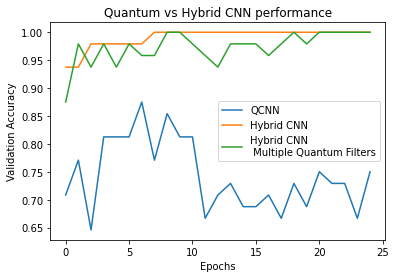

In [28]:
plt.plot(history.history['val_custom_accuracy'][:25], label='QCNN')
plt.plot(hybrid_history.history['val_custom_accuracy'][:25], label='Hybrid CNN')
plt.plot(multi_qconv_history.history['val_custom_accuracy'][:25],
         label='Hybrid CNN \n Multiple Quantum Filters')
plt.title('Quantum vs Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()